In [23]:
"""
# Solo ejecutar esta celda si no tienes las trazas de los datos

import gdown
import zipfile
import os

file_id = '1D1gExECJbpmKupMuTisrZ3_9NMBVkD49'
output = 'datos.zip'

gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(output)
"""

"\n# Solo ejecutar esta celda si no tienes las trazas de los datos\n\nimport gdown\nimport zipfile\nimport os\n\nfile_id = '1D1gExECJbpmKupMuTisrZ3_9NMBVkD49'\noutput = 'datos.zip'\n\ngdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output, quiet=False)\n\nwith zipfile.ZipFile(output, 'r') as zip_ref:\n    zip_ref.extractall()\n\nos.remove(output)\n"

In [24]:
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import pickle

np.random.seed(0)

In [25]:
def save_object(o, name):
    # open a file
    with open(name,'wb') as f:
        # dump object to that file
        pickle.dump(o,f)
    
def load_object(name):
    # open a file, where you stored the pickled data
    with open(name,'rb') as f:
        return pickle.load(f)

In [26]:
trozoG = pd.read_csv("Datos/TrozoG.txt", names = ["LP", "VD","T"],
                     usecols = [0, 1, 2],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoG.head(10)

,LP,VD,T
0,-0.006104,0.064697,0.120239
1,-0.004272,0.075989,0.126343
2,-0.003357,0.087280,0.125427
3,-0.005188,0.092468,0.123596
4,-0.007324,0.093384,0.118713
5,-0.010681,0.089722,0.105896
6,-0.004883,0.086975,0.127258
7,0.004272,0.092468,0.111084
8,0.002441,0.087585,0.114136
9,0.003357,0.080872,0.110779


C:\Users\imcir\AppData\Local\Temp\ipykernel_41428\3650936539.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis',cols + len(lines))


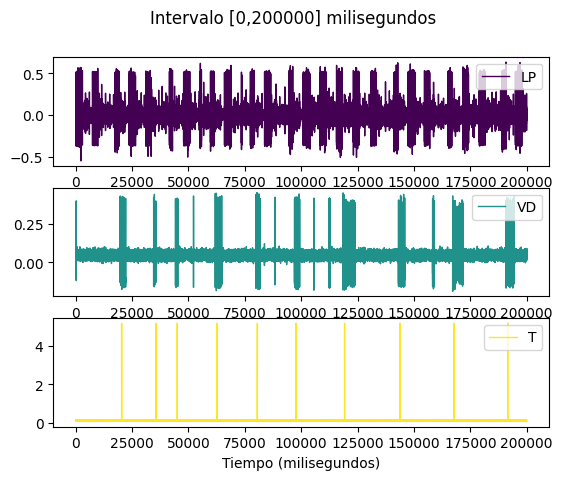

In [27]:
def plot_data_interval_lines(
            data: pd.DataFrame = trozoG, 
            lines: list = [], 
            lines_titles: list = [], 
            x: list = [0,10000]
    ):
    
    cols = len(data.columns)
    if len(lines) > 0 and len(lines) != cols:
        raise ValueError("Incorrect number of lines passed")
    
    x_values = np.arange(x[0],x[1],1)
    
    colors = plt.cm.get_cmap('viridis',cols + len(lines))

    fig, axs = plt.subplots(cols)
    fig.suptitle('Intervalo [{},{}] milisegundos'.format(x[0],x[1]))

    for j in range(cols):
        axs[j].plot(x_values, data.iloc[:, j][x[0]:x[1]], label = data.columns[j],color = colors(j),linewidth = 1)
        if len(lines) > 0:
            y_values = [lines[j] for i in x_values]
            axs[j].plot(x_values,y_values,color = colors(j+cols),label = lines_titles[j], linewidth = 1)
            
        axs[j].legend(loc="upper right")
        

    axs[cols-1].set_xlabel('Tiempo (milisegundos)')
    plt.show()

plot_data_interval_lines(trozoG, x = [0,200000])

Estos histogramas los he creado para ver más o menos las distribuciones de amplitudes de tal forma que podemos ver cuándo aumentan, es decir, que aparece el grupo de las spikes, frente al grupo del estado en reposo. Es un poco difuso las distinciones y no sé si hay alguna forma mejor de separarlas que a ojo, pero bueno. 99,7% que es lo que habían hecho Sáez y compañía me parece excesivo pero no estoy seguo. Siempre podemos preguntar al profesor o a cualquiera de estos el criterio que han seguido.

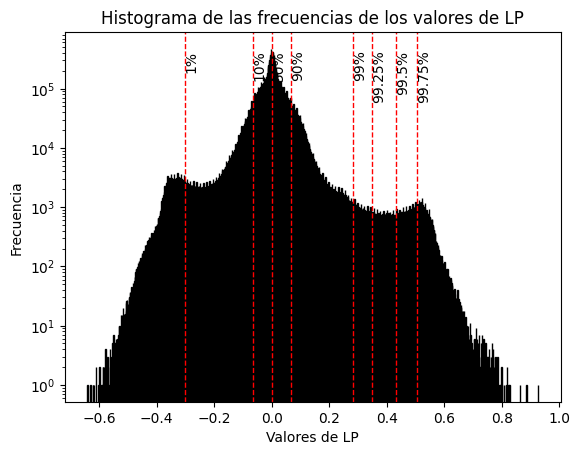

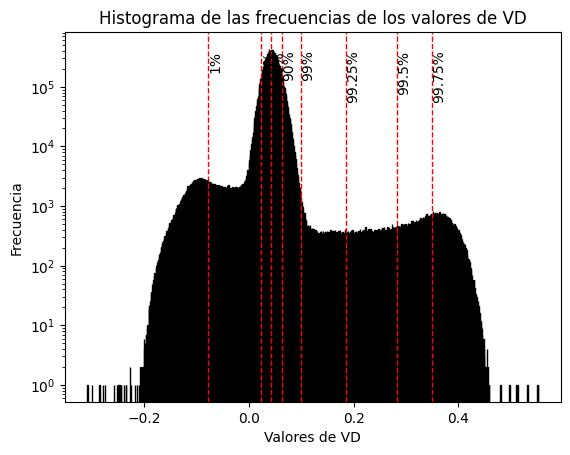

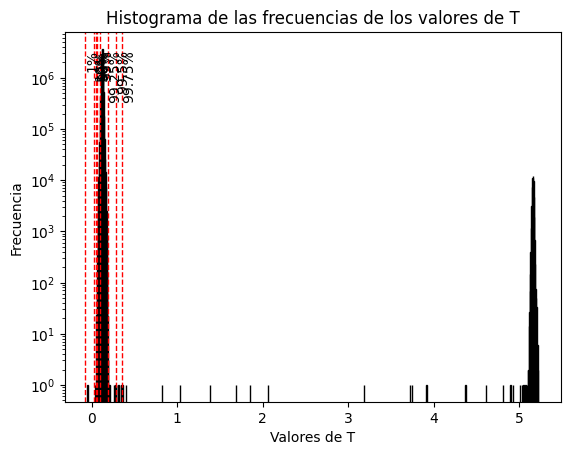

In [28]:
percentiles = [1, 10, 50, 90, 99, 99.25, 99.5, 99.75]

decilesLP = np.percentile(trozoG['LP'], percentiles)
plt.hist(trozoG['LP'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesLP, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de LP')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de LP')
plt.yscale('log')
plt.show()

decilesVD = np.percentile(trozoG['VD'], percentiles)
plt.hist(trozoG['VD'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesVD, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de VD')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de VD')
plt.yscale('log')
plt.show()

decilesT = np.percentile(trozoG['T'], percentiles)
plt.hist(trozoG['T'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesVD, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de T')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de T')
plt.yscale('log')
plt.show()

In [29]:
def get_percentiles(data: pd.DataFrame,
                    q: list = []
                    ):
    perc = data.quantile(q)
    return np.diag(perc)

Percentiles:
 [0.432129 0.282593 5.151672]


C:\Users\imcir\AppData\Local\Temp\ipykernel_41428\3650936539.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis',cols + len(lines))


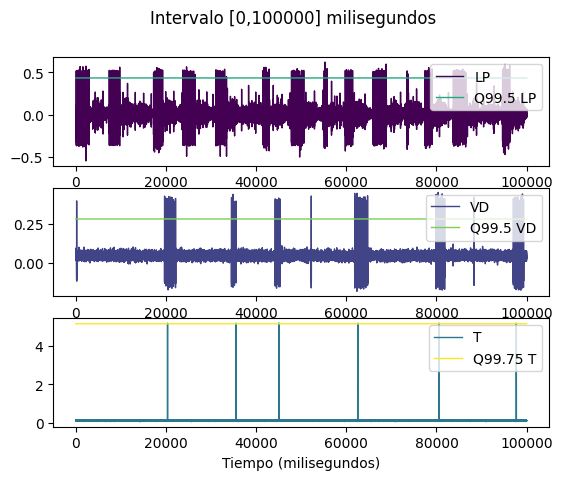

In [30]:
perc = get_percentiles(trozoG, q=[0.995, 0.995, 0.9975])
print("Percentiles:\n {}".format(perc))
plot_data_interval_lines(trozoG,
                         lines = perc,
                         lines_titles = ["Q99.5 LP", "Q99.5 VD", "Q99.75 T"],
                         x = [0,100000])

C:\Users\imcir\AppData\Local\Temp\ipykernel_41428\3650936539.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis',cols + len(lines))


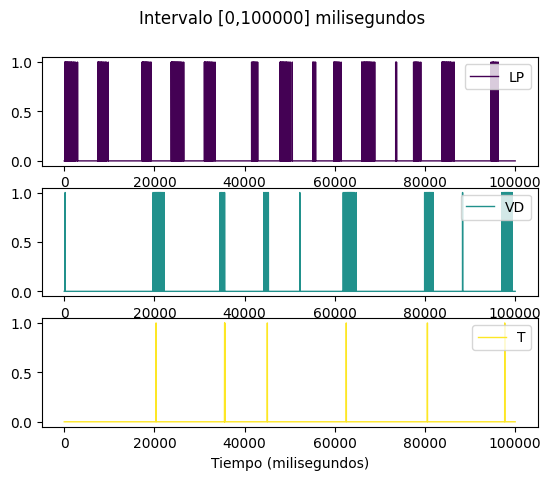

In [31]:
trozoG_umbral = (trozoG > perc).astype(int)
plot_data_interval_lines(trozoG_umbral, x =[0,100000]) 

In [32]:
trozoG_umbral.iloc[20320:20340,:]

,LP,VD,T
20320,0,0,0
20321,0,0,0
20322,0,0,0
20323,0,0,0
20324,0,0,0
20325,0,0,0
20326,0,0,0
20327,0,0,0
20328,0,1,0
20329,0,1,0


In [33]:
def _process_consecutive_ones_vector(vec, i):
    start = i
    while i < len(vec) and vec[i] == 1:
        i += 1
    end = i
    vec[start:end] = 0
    vec[start] = 1
    return i+1  # Devuelve la posicion del siguiente valor despues del 0 que sigue al spike

def minimize_ones_in_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
        Ejecución in place
    """
    for col in range(len(df.columns)):
        vec = np.array(df.iloc[:, col])
        i = 0
        while i < len(vec):
            if vec[i] == 1:
                i = _process_consecutive_ones_vector(vec, i)
            else:
                i += 1
        df.iloc[:, col] = vec
    return df

In [34]:
trozoG_minimizado = minimize_ones_in_dataframe(trozoG_umbral.copy())
trozoG_minimizado.iloc[20320:20340,:]

,LP,VD,T
20320,0,0,0
20321,0,0,0
20322,0,0,0
20323,0,0,0
20324,0,0,0
20325,0,0,0
20326,0,0,0
20327,0,0,0
20328,0,1,0
20329,0,0,0


In [35]:
import itertools

def get_zeros_between_spikes(df: pd.DataFrame) -> list[list]:
    arrays_zeros = [ [] for i in range(len(df.columns)) ]
    for idx,col in enumerate(df.columns):
        dtype = [('spike',int),('length',int)]
        vector = np.array([ (x , len(list(y)))
                    for x, y in itertools.groupby(df[col].values)],
                    dtype=dtype)
        sorted_vector = np.sort(vector,order=['spike','length'])
        arrays_zeros[idx] = np.array([v[1] for v in sorted_vector if v[0] == 0])
    return arrays_zeros

spaces_between_ones_sorted_G = get_zeros_between_spikes(trozoG_minimizado)
spaces_between_ones_sorted_G

[array([   24,    25,    44, ..., 12603, 12718, 14119]),
 array([   62,    63,    64, ..., 20802, 21351, 21408]),
 array([    1,     1,     1, ..., 44643, 72092, 76316])]

In [36]:
def plot_histograms_zoom(trace: list, yscale: str = 'log', xlims: list[int] = [750,200]):
    import seaborn as sns

    xlims_ = sorted(xlims, reverse=True)

    trace_np = np.array(trace, dtype=np.float32)

    _ , bins = np.histogram(trace_np, bins='auto')

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(trace_np, bins=bins, ax=ax1)
    sns.histplot(trace_np, bins=bins, ax=ax2)
    sns.histplot(trace_np, bins=bins, ax=ax3)

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel("")

    ax2.set_xlim(0, xlims_[0])
    ax3.set_xlim(0, xlims_[1])

    for ax in [ax1, ax2, ax3]:
        ax.set_yscale(yscale)

    plt.tight_layout()
    plt.show()

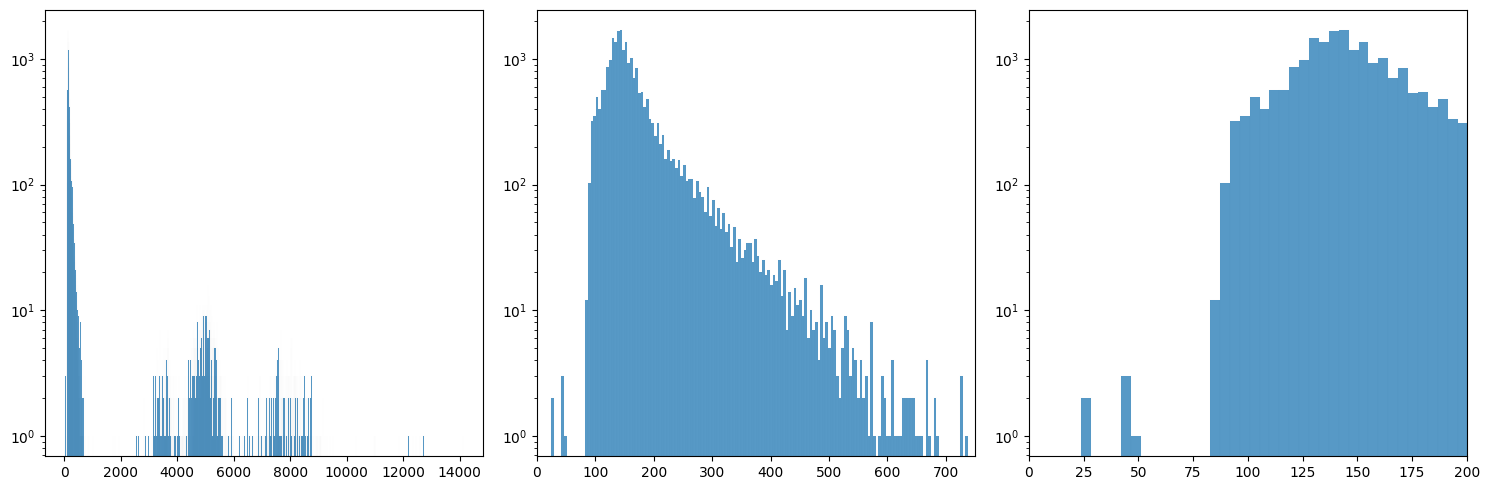

In [37]:
plot_histograms_zoom(spaces_between_ones_sorted_G[0])

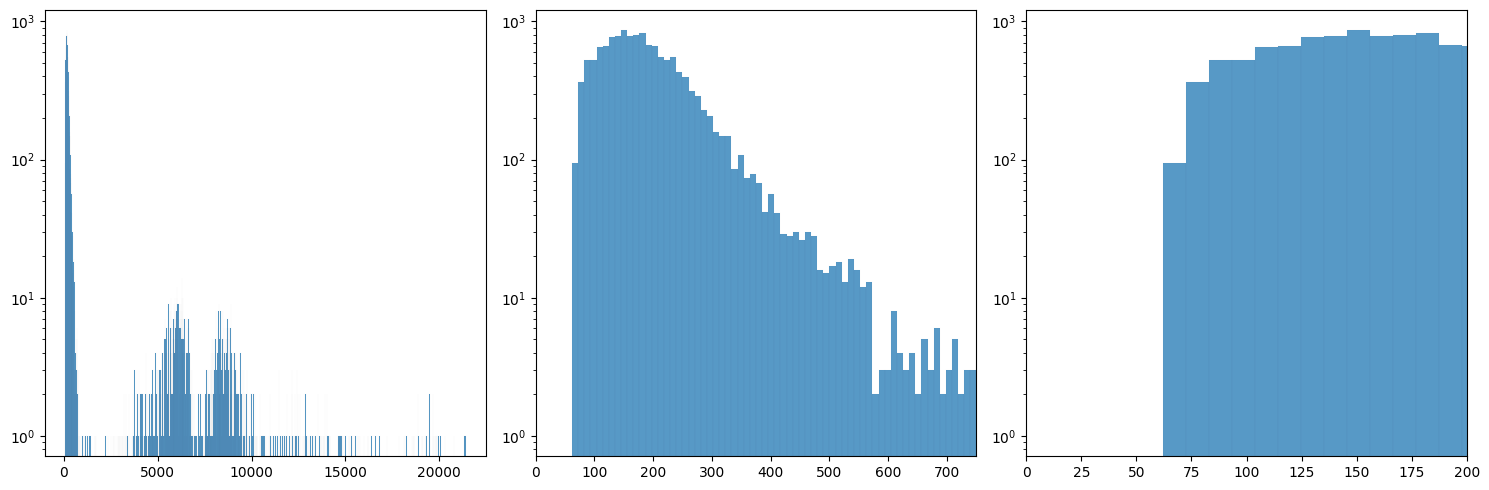

In [38]:
plot_histograms_zoom(spaces_between_ones_sorted_G[1])

In [39]:
def remove_outliers(df: pd.DataFrame, threshold_outlier: int = 55) -> pd.DataFrame:
    df_ = df.copy()
    
    for col in df_.columns:
        col_data = df_[col].values

        change_points = np.diff(col_data, prepend=col_data[0])
        run_starts = np.where(change_points != 0)[0]
        run_lengths = np.diff(np.append(run_starts, len(col_data)))
        
        zero_run_indices = np.where((col_data[run_starts] == 0) & (run_lengths < threshold_outlier))[0]
        
        for idx in zero_run_indices:
            start = run_starts[idx]
            end = start + run_lengths[idx]
            
            if start > 0:
                col_data[start - 1] = 0
            if end < len(col_data):
                col_data[end] = 0

        df_[col] = col_data

    return df_

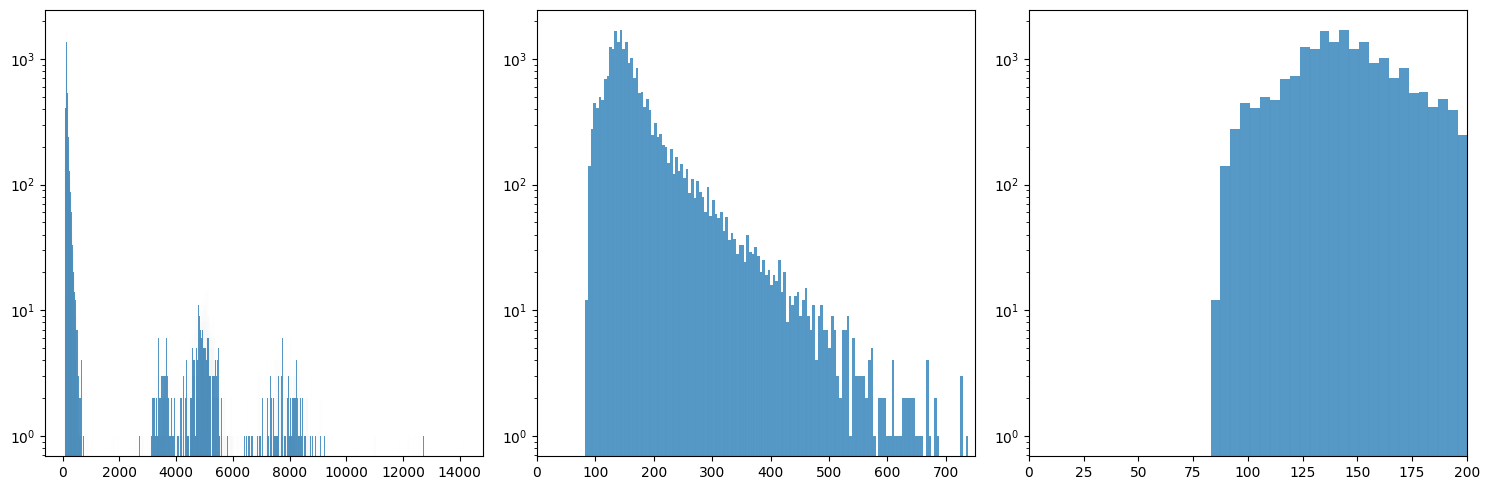

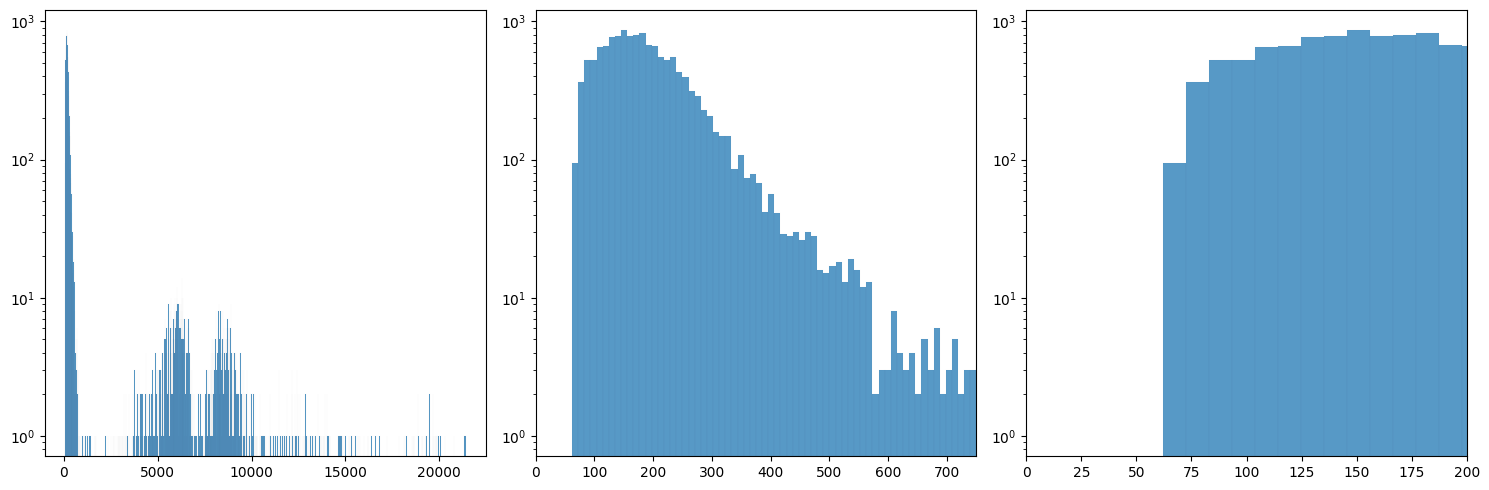

In [40]:
trozoG_no_outliers = remove_outliers(trozoG_minimizado)
spaces_no_outliers_G = get_zeros_between_spikes(trozoG_no_outliers)

for traza in spaces_no_outliers_G[:2]:
    plot_histograms_zoom(trace=traza)

In [66]:
def get_min_spaces(spaces: list[list]) -> int:

    return min(int(space_min[0]) for space_min in spaces)

windows_size_G = get_min_spaces(spaces_no_outliers_G)

In [67]:
def reduce_with_window(df, window_size):
    index = np.arange(0, len(df) + 1, window_size)
    
    result = np.zeros((len(index) - 1, df.shape[1]), dtype=int)
    
    for i, col in enumerate(df.columns):
        data = df[col].values
        for j, (i1, i2) in enumerate(zip(index[:-1], index[1:])):
            if np.any(data[i1:i2] == 1):
                result[j, i] = 1
    
    return pd.DataFrame(result, columns=df.columns)

In [86]:
def _create_discretization(trace: pd.DataFrame, q: list[int]) -> pd.DataFrame:
    perc = get_percentiles(trace, q=q)
    trace_threshold = (trace > perc).astype(int)
    trace_minimized = minimize_ones_in_dataframe(trace_threshold.copy())
    return remove_outliers(trace_minimized)

def _create_reduction(trace_no_outliners: pd.DataFrame, windows_size: int = None) -> pd.DataFrame:
    if not windows_size:
        spaces = get_zeros_between_spikes(trace_no_outliners)

        windows_size = get_min_spaces(spaces)

        print(f"Tamaño de ventana {windows_size}")
    return reduce_with_window(trace_no_outliners, windows_size)

def compute_trace(trace: pd.DataFrame, q: list[int], windows_size: int = None) -> pd.DataFrame:
    discretized_trace = _create_discretization(trace, q)
    return _create_reduction(discretized_trace, windows_size)

trozoG_reducido = compute_trace(trozoG, [0.995, 0.995, 0.9975])

Tamaño de ventana 62
Tamaño de ventana 62


In [87]:
len(trozoG_reducido.iloc[:,0])/len(trozoG.iloc[:,0])*100

1.61290283203125

## TROZO C

In [45]:
trozoC = pd.read_csv("Datos/TrozoC.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoC.head(10)

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471
5,-0.034180,0.047913
6,-0.045166,0.058899
7,-0.048523,0.057068
8,-0.049438,0.062256
9,-0.048828,0.064697


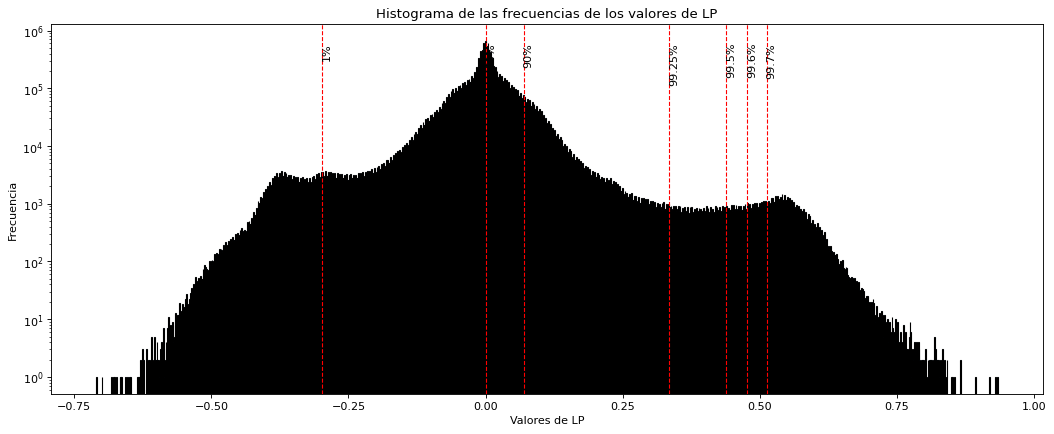

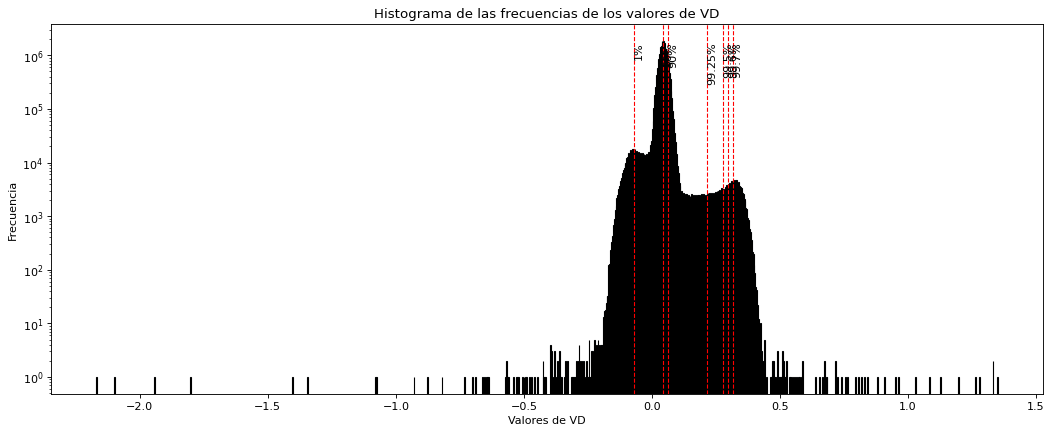

In [59]:
percentiles = [1, 50, 90, 99.25, 99.5, 99.6, 99.7]

decilesLP = np.percentile(trozoC['LP'], percentiles)
plt.figure(figsize=(16, 6), dpi=80)
plt.hist(trozoC['LP'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesLP, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de LP')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de LP')
plt.yscale('log')
plt.show()

decilesVD = np.percentile(trozoC['VD'], percentiles)
plt.figure(figsize=(16, 6), dpi=80)
plt.hist(trozoC['VD'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesVD, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de VD')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de VD')
plt.yscale('log')
plt.show()

In [88]:
trozoC_reducido = compute_trace(trozoC, [0.996, 0.995])

Tamaño de ventana 60


In [89]:
len(trozoC_reducido.iloc[:,0])/len(trozoC.iloc[:,0])*100

1.6666666666666667

## TROZO R

In [48]:
trozoR = pd.read_csv("Datos/TrozoR.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoR.head(10)

,LP,VD
0,-0.008240,0.084534
1,-0.009460,0.070190
2,-0.014038,0.049133
3,-0.021973,0.035400
4,-0.035095,0.022888
5,-0.042114,0.008850
6,-0.047607,0.009460
7,-0.057678,0.012207
8,-0.061646,0.018311
9,-0.086060,0.021973


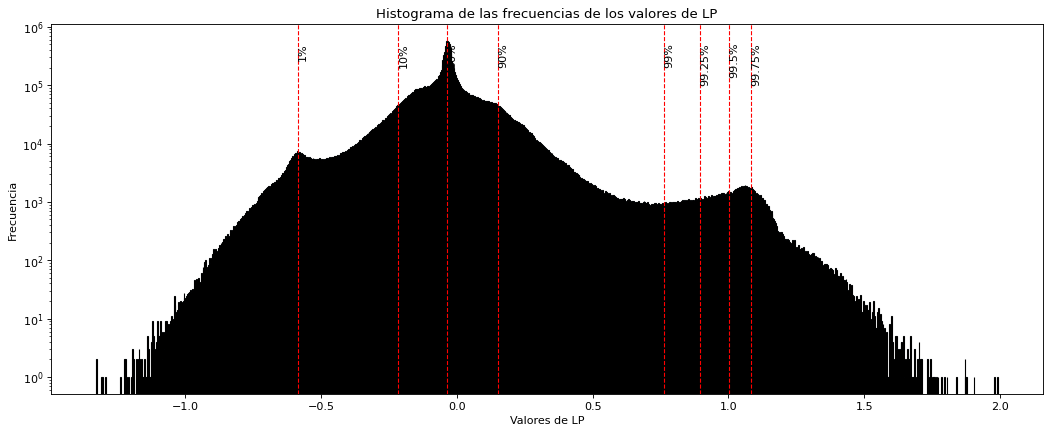

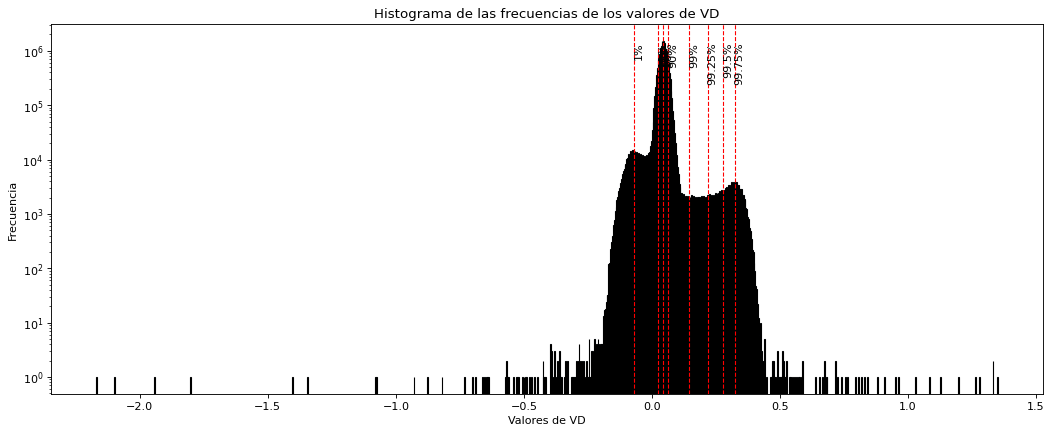

In [58]:
percentiles = [1, 10, 50, 90, 99, 99.25, 99.5, 99.75]

decilesLP = np.percentile(trozoR['LP'], percentiles)
plt.figure(figsize=(16, 6), dpi=80)
plt.hist(trozoR['LP'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesLP, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de LP')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de LP')
plt.yscale('log')
plt.show()

decilesVD = np.percentile(trozoR['VD'], percentiles)
plt.figure(figsize=(16, 6), dpi=80)
plt.hist(trozoR['VD'], bins=1000, edgecolor='black')
for decil, perc in zip(decilesVD, percentiles):
    plt.axvline(decil, color='red', linestyle='dashed', linewidth=1)
    plt.text(decil, plt.ylim()[1] * 0.9, f'{perc}%', rotation=90, verticalalignment='top')
plt.xlabel('Valores de VD')
plt.ylabel('Frecuencia')
plt.title('Histograma de las frecuencias de los valores de VD')
plt.yscale('log')
plt.show()

In [90]:
trozoR_reducido = compute_trace(trozoR, [0.995, 0.995])

Tamaño de ventana 25


In [91]:
len(trozoR_reducido.iloc[:,0])/len(trozoR.iloc[:,0])*100

4.0